In [1]:
import sqlite3
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from babel.dates import format_datetime
import contextily as ctx
import seaborn as sns


from meteostat import Point, Hourly
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

In [2]:
conn = sqlite3.connect("my_data.db")

# Load the merged data
data_stations = pd.read_sql("SELECT * FROM stations", conn)
data_localisation = pd.read_sql("SELECT * FROM localisation", conn)

conn.close()

In [3]:
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.facecolor"] = 'w'

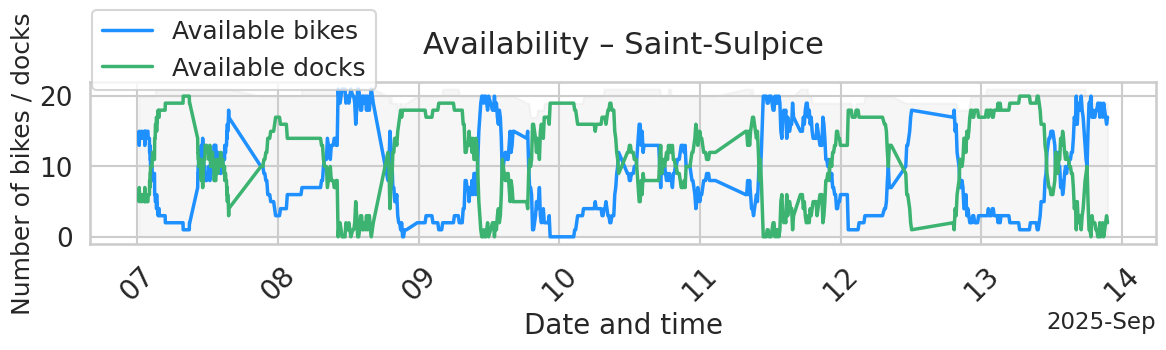

In [17]:
# --- Selecting a specific station ---
station_id = 37874517  # 👉 Change the ID to the station you want
station_data = data_stations[data_stations["station_id"] == station_id].copy()
station_info = data_localisation[data_localisation["station_id"] == station_id]

# Convert to datetime and sort
station_data["time_stamp"] = pd.to_datetime(station_data["time_stamp"], errors="coerce")
station_data = station_data.sort_values("time_stamp")

sns.set_style("whitegrid")
sns.set_context("talk")

fig, ax = plt.subplots(figsize=(12, 5))  # Slightly taller figure

ax.plot(station_data["time_stamp"], station_data["num_bikes_available"],
        linestyle='-', linewidth=2.5, color='dodgerblue', label='Available bikes')  # Thicker line
ax.plot(station_data["time_stamp"], station_data["num_docks_available"],
        linestyle='-', linewidth=2.5, color='mediumseagreen', label='Available docks')  # Thicker line

# Fill between for overall capacity
ax.fill_between(station_data["time_stamp"], 0,
                station_data["num_bikes_available"] + station_data["num_docks_available"],
                color='lightgray', alpha=0.2)

# X-axis formatting
# Axes
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
#ax.xaxis.set_major_locator(mdates.AutoDateLocator())
#ax.xaxis.set_major_formatter(
#    mdates.ConciseDateFormatter(mdates.AutoDateLocator(), show_offset=False)
#)
ax.tick_params(axis='x', rotation=45, labelsize=20)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.tick_params(axis='x', rotation=45, labelsize=20)  # Larger tick labels
ax.tick_params(axis='y', labelsize=19)  # Larger tick labels

# Titles and labels with larger font sizes
station_name = station_info['name'].values[0] if not station_info.empty else f"Station {station_id}"
ax.set_title(f"Availability – {station_name}", fontsize=22, pad=20)  # Larger title
ax.set_ylabel("Number of bikes / docks", fontsize=18)  # Larger y-label
ax.set_xlabel("Date and time", fontsize=20)  # Larger x-label

# Legend with larger text
ax.legend(loc='upper left', bbox_to_anchor=(-0.01, 1.52), fontsize=18)

plt.tight_layout()
plt.savefig("station_availability.png", dpi=150, bbox_inches='tight')
plt.show()

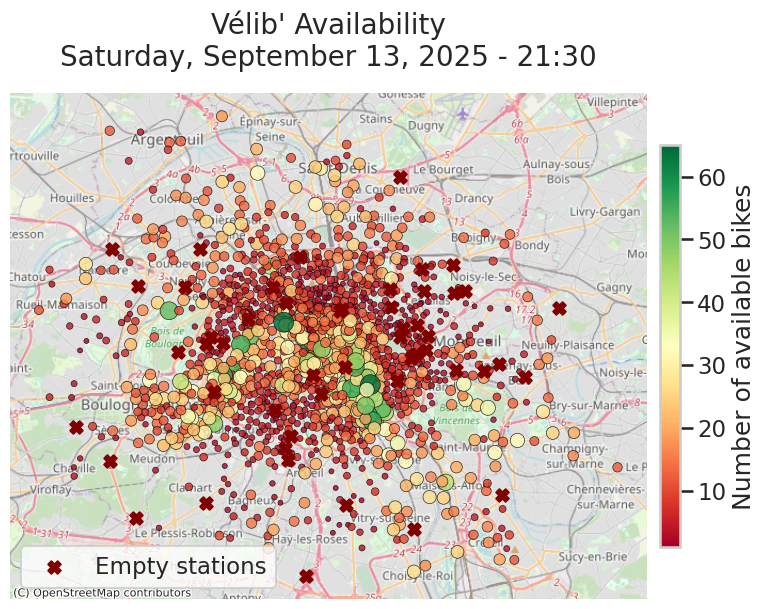

In [5]:
data_stations = data_stations.merge(data_localisation, on="station_id")

# Conversion to GeoDataFrame
geometry = gpd.points_from_xy(data_stations["lon"], data_stations["lat"])
geo_stations = gpd.GeoDataFrame(data_stations, crs="EPSG:4326", geometry=geometry)

# Convert timestamp to datetime
geo_stations["time_stamp"] = pd.to_datetime(geo_stations["time_stamp"])

# Select the latest timestamp
some_time = geo_stations["time_stamp"].max()
some_data = geo_stations[geo_stations["time_stamp"] == some_time].copy()
some_data = some_data.to_crs(epsg=3857)

# --- Create the map ---
fig, ax = plt.subplots(figsize=(8, 8))

# Separate empty and non-empty stations
empty_stations = some_data[some_data["num_bikes_available"] == 0]
non_empty_stations = some_data[some_data["num_bikes_available"] > 0]

# Plot non-empty stations (color gradient)
non_empty_stations.plot(
    column="num_bikes_available", 
    markersize=non_empty_stations["num_bikes_available"] * 3 + 10,
    cmap="RdYlGn", 
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5,
    legend=False,
    ax=ax
)

# Plot empty stations (dark red crosses)
empty_stations.plot(
    ax=ax,
    markersize=80,
    marker="X",
    color="#800000",
    label="Empty stations"
)

# Add a compact colorbar
if not non_empty_stations.empty:
    sm = plt.cm.ScalarMappable(
        cmap="RdYlGn",
        norm=plt.Normalize(
            vmin=non_empty_stations["num_bikes_available"].min(),
            vmax=non_empty_stations["num_bikes_available"].max()
        )
    )
    sm._A = []  # Matplotlib hack
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
    cbar.set_label("Number of available bikes")

# Format date in English
date_str = format_datetime(some_time, "EEEE, MMMM d, y - HH:mm", locale="en_US")

# Title
ax.set_title(
    f"Vélib' Availability\n{date_str}",
    fontsize=20, pad=20
)

# Background map
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.8)

# Remove axes
ax.set_axis_off()

# Manual legend for the crosses
ax.legend(loc="lower left")

plt.tight_layout()
plt.savefig("Velib_availability.png", dpi=150, bbox_inches='tight')
plt.show()

Districts found: ['Arts-et-Métiers', 'Belleville', 'Bercy', 'Champs-Elysées', 'Père-Lachaise']


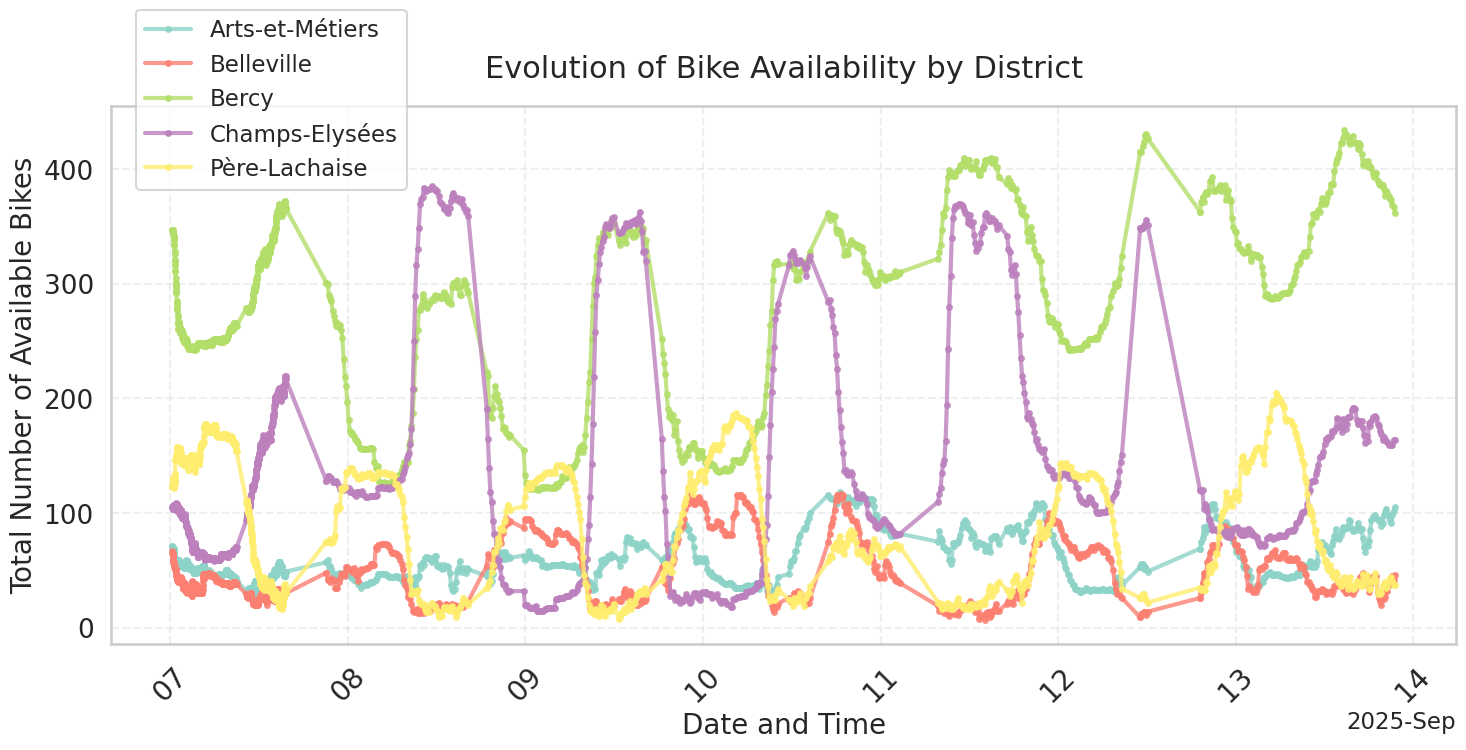

📊 Statistics by district:


Mean  Max  Min  Std Dev
District                                 
Arts-et-Métiers   54.1  118   25     18.7
Belleville        43.2  117    7     22.3
Bercy            281.1  434  120     70.5
Champs-Elysées   130.4  385   15     89.0
Père-Lachaise    100.3  205    8     57.8

In [20]:
# --- Load districts ---
districts = gpd.read_file("quartier_paris.geojson")

# --- Merge stations + location tables ---
data_merged = data_stations

# Convert to GeoDataFrame
geo_stations = gpd.GeoDataFrame(
    data_merged,
    crs="EPSG:4326",
    geometry=gpd.points_from_xy(data_merged["lon"], data_merged["lat"])
)

# Clean unnecessary columns
cols_to_drop_stations = ["stationCode", "name", "lon", "lat"] + [col for col in geo_stations.columns if 'index' in col]
geo_stations.drop(columns=cols_to_drop_stations, errors='ignore', inplace=True)
cols_to_drop_districts = ["n_sq_qu", "n_sq_ar", "c_qu", "surface", "perimetre", "c_quinsee", "c_ar"]
districts.drop(columns=cols_to_drop_districts, errors='ignore', inplace=True)

# Spatial join
geo_districts = gpd.sjoin(districts, geo_stations, how="left", predicate="contains")

# Aggregation by district and time
occupation_data = geo_districts.groupby(["l_qu", "time_stamp"], as_index=False).agg({
    "num_bikes_available": "sum",
    "geometry": "first"
})

# Convert timestamp
occupation_data["time_stamp"] = pd.to_datetime(occupation_data["time_stamp"])

# --- FILTER: Specific districts ---
selected_districts = [
    "Arts-et-Métiers", 
    "Bercy", 
    "Champs-Elysées",  
    "Belleville",
    "Père-Lachaise"
]
occupation_data_filtered = occupation_data[occupation_data["l_qu"].isin(selected_districts)]
found_districts = occupation_data_filtered["l_qu"].unique()
print(f"Districts found: {list(found_districts)}")

# --- Create the plot ---
fig, ax = plt.subplots(figsize=(15, 8))

# Colors for districts
colors = plt.cm.Set3(np.linspace(0, 1, len(found_districts)))

# Plot districts
for i, district in enumerate(found_districts):
    district_data = occupation_data_filtered[occupation_data_filtered["l_qu"] == district].sort_values("time_stamp")
    ax.plot(district_data["time_stamp"], district_data["num_bikes_available"],
            label=district, linewidth=3, alpha=0.8, color=colors[i],
            marker='o', markersize=4)

# Format X-axis with AutoDateLocator + ConciseDateFormatter
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.tick_params(axis='x', rotation=45, labelsize=20)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.tick_params(axis='y', labelsize=19)  # Larger tick labels




# Title and labels
ax.set_title("Evolution of Bike Availability by District",
             fontsize=22, pad=20)
ax.set_ylabel("Total Number of Available Bikes", fontsize=20)
ax.set_xlabel("Date and Time", fontsize=20)

# Grid + legend
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(bbox_to_anchor=(0.01, 1.2), loc='upper left', frameon=True, fancybox=True)


plt.tight_layout()
plt.savefig("evoBYdistrict.png", dpi=150, bbox_inches='tight')
plt.show()

# --- District statistics ---
district_stats = occupation_data_filtered.groupby("l_qu")["num_bikes_available"].agg(['mean', 'max', 'min', 'std'])
district_stats = district_stats.rename(columns={
    'mean': 'Mean', 
    'max': 'Max', 
    'min': 'Min', 
    'std': 'Std Dev'
})
district_stats.index.name = "District"
print("📊 Statistics by district:")
display(district_stats.round(1))

🚴 1472 stations analyzed (after cleaning):
🔍 148 atypical stations detected


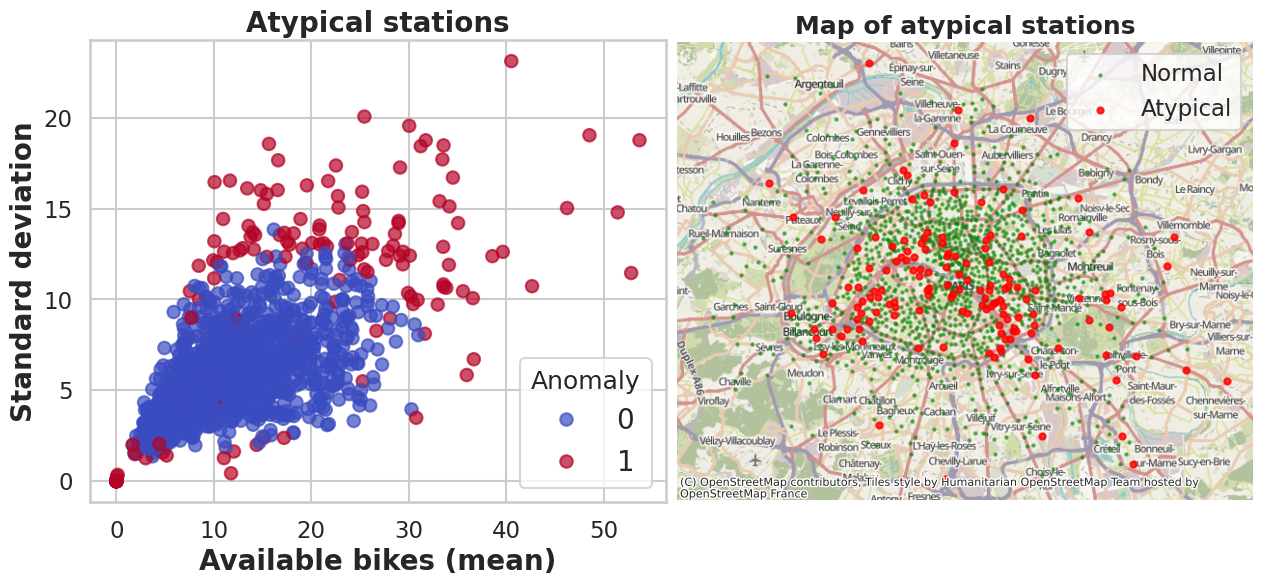


🚨 Always full stations (over-utilization): 14
🚨 Always empty stations (under-utilization): 5


In [22]:
# Station analysis with NaN handling
station_behavior = data_merged.groupby('station_id').agg({
    'num_bikes_available': ['mean', 'std', 'count'],
    'num_docks_available': ['mean', 'std'],
    'lat': 'first',
    'lon': 'first'
})

station_behavior.columns = ['_'.join(col).strip() for col in station_behavior.columns.values]

# Filter stations with enough data and no NaN values
station_behavior_clean = station_behavior[
    (station_behavior['num_bikes_available_count'] > 10) &
    (station_behavior['num_bikes_available_mean'].notna()) &
    (station_behavior['num_bikes_available_std'].notna())
].copy()

print(f"🚴 {len(station_behavior_clean)} stations analyzed (after cleaning):")

if len(station_behavior_clean) > 10:  # Minimum for analysis
    # Features for anomaly detection
    features = station_behavior_clean[['num_bikes_available_mean', 'num_bikes_available_std', 
                                    'num_docks_available_mean', 'num_docks_available_std']]
    
    # Anomaly detection with Isolation Forest
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    anomalies = iso_forest.fit_predict(features)
    
    station_behavior_clean['anomaly_score'] = iso_forest.decision_function(features)
    station_behavior_clean['is_anomaly'] = anomalies == -1
    
    print(f"🔍 {station_behavior_clean['is_anomaly'].sum()} atypical stations detected")
    
    # Anomaly visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'height_ratios': [1]})
    
    # --- Left panel: Scatter ---
    scatter = axes[0].scatter(
        station_behavior_clean['num_bikes_available_mean'], 
        station_behavior_clean['num_bikes_available_std'],
        c=station_behavior_clean['is_anomaly'], cmap='coolwarm', alpha=0.7
    )
    axes[0].set_xlabel('Available bikes (mean)', fontweight='bold', fontsize=20)
    axes[0].set_ylabel('Standard deviation', fontweight='bold', fontsize=20)
    axes[0].set_title('Atypical stations', fontweight='bold', fontsize=20)
    axes[0].legend(*scatter.legend_elements(), title="Anomaly", fontsize=20)

    # Anomaly map
    anomaly_stations = station_behavior_clean[station_behavior_clean['is_anomaly']].copy()
    normal_stations = station_behavior_clean[~station_behavior_clean['is_anomaly']].copy()
    
    # --- Right panel: Map ---
    if not anomaly_stations.empty:
        anomaly_gdf = gpd.GeoDataFrame(
            anomaly_stations,
            geometry=gpd.points_from_xy(anomaly_stations['lon_first'], anomaly_stations['lat_first']),
            crs='EPSG:4326'
        ).to_crs(epsg=3857)
        
        normal_gdf = gpd.GeoDataFrame(
            normal_stations,
            geometry=gpd.points_from_xy(normal_stations['lon_first'], normal_stations['lat_first']),
            crs='EPSG:4326'
        ).to_crs(epsg=3857)
        
        normal_gdf.plot(ax=axes[1], color='green', markersize=3, alpha=0.5, label='Normal')
        anomaly_gdf.plot(ax=axes[1], color='red', markersize=20, alpha=0.8, label='Atypical')
        ctx.add_basemap(axes[1])
        axes[1].set_axis_off()
        axes[1].set_title('Map of atypical stations', fontweight='bold')
        axes[1].legend()
    
    # Align panels nicely
    plt.subplots_adjust(wspace=0.02)
    plt.savefig("Anomaly.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    # --- Definition of always full/empty stations ---
    always_full = station_behavior_clean[
        (station_behavior_clean['num_bikes_available_mean'] == 0) &
        (station_behavior_clean['num_bikes_available_std'] == 0)
    ]
    always_empty = station_behavior_clean[
        (station_behavior_clean['num_docks_available_mean'] == 0) &
        (station_behavior_clean['num_docks_available_std'] == 0)
    ]
    
    # Detailed analysis of atypical stations
    if not anomaly_stations.empty:
        if not always_full.empty:
            print(f"\n🚨 Always full stations (over-utilization): {len(always_full)}")
        if not always_empty.empty:
            print(f"🚨 Always empty stations (under-utilization): {len(always_empty)}")
    else:
        print("✅ No atypical stations detected")
else:
    print("❌ Not enough stations with complete data for analysis")

📊 Time series shape: (80, 1553, 1)
🏷️ Districts analyzed: 80


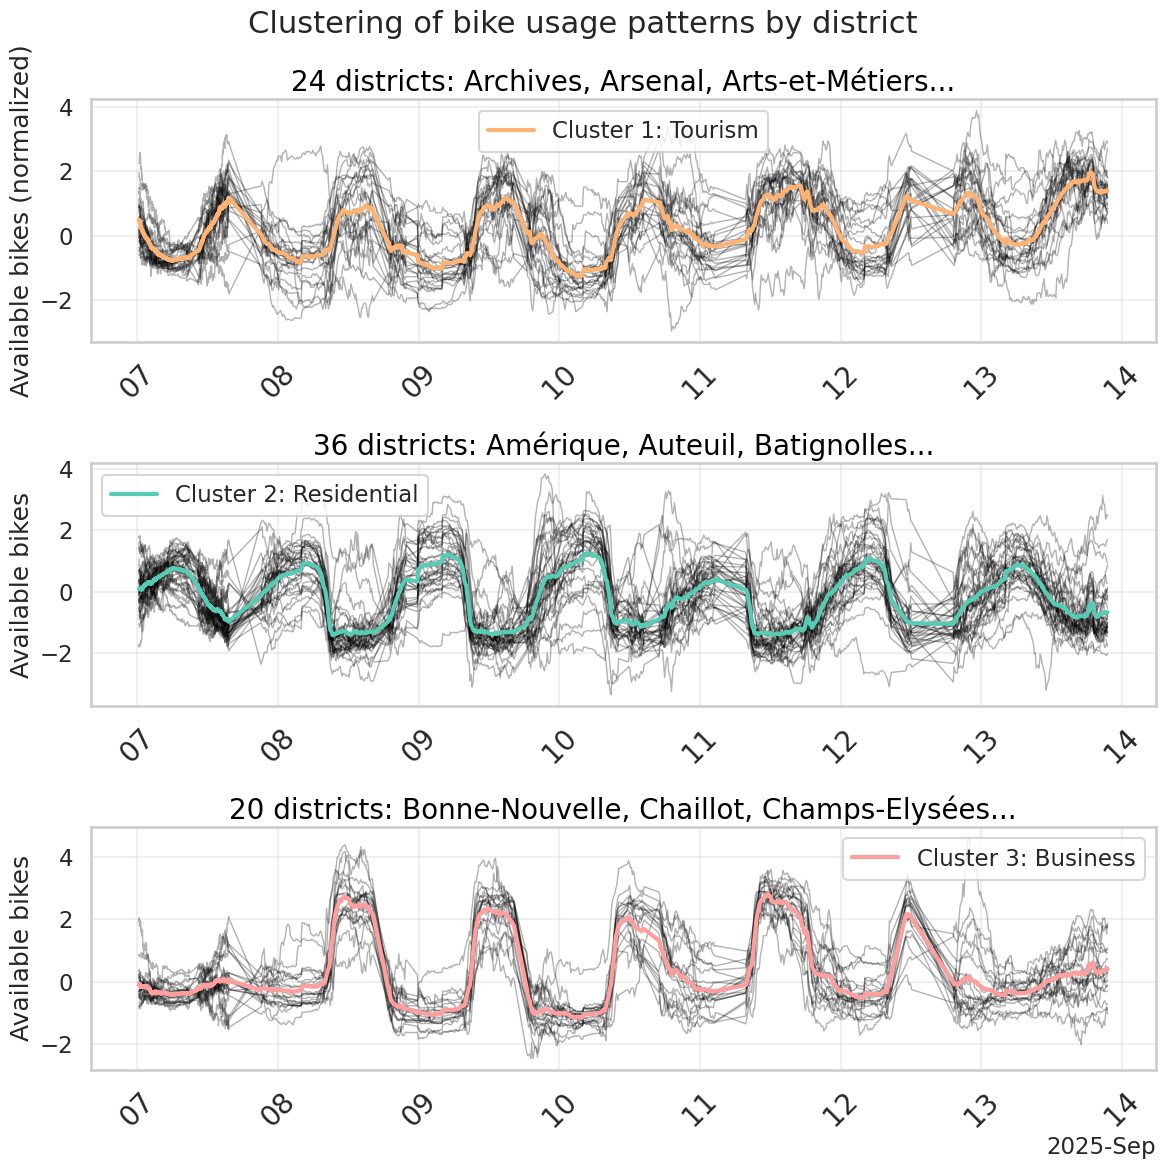


🎯 CLUSTER SUMMARY:
Cluster 1: 24 districts
   Districts: Archives, Arsenal, Arts-et-Métiers, Bercy, Enfants-Rouges...
Cluster 2: 36 districts
   Districts: Amérique, Auteuil, Batignolles, Bel-Air, Belleville...
Cluster 3: 20 districts
   Districts: Bonne-Nouvelle, Chaillot, Champs-Elysées, Chaussée-d'Antin, Ecole-Militaire...


In [26]:
# with 3 clusters
interpretation = ["Tourism","Residential","Business"]
colors = ["#FFB271","#56CCB5", "#FF9E9E"]

# --- Data preparation for clustering ---
labels, time_series_list = [], []
for l_qu, group in occupation_data.groupby("l_qu"):
    labels.append(l_qu)
    time_series_list.append(group["num_bikes_available"].values)

# Convert to time series format and normalize
time_series = to_time_series_dataset(time_series_list)
time_series = TimeSeriesScalerMeanVariance().fit_transform(time_series)

print(f"📊 Time series shape: {time_series.shape}")
print(f"🏷️ Districts analyzed: {len(labels)}")

# --- K-means clustering ---
n_classes = 3
model = TimeSeriesKMeans(n_clusters=n_classes, metric="euclidean", random_state=42)
model.fit(time_series)

# --- Cluster visualization ---
fig = plt.figure(figsize=(12, n_classes * 4))
time_labels = pd.to_datetime(occupation_data["time_stamp"].unique())
time_labels_sorted = sorted(time_labels)

for yi in range(n_classes):
    ax = fig.add_subplot(n_classes, 1, yi + 1)
    
    # Series in this class
    for xx in time_series[model.labels_ == yi]:
        ax.plot(time_labels_sorted, xx.ravel(), "k-", alpha=.3, linewidth=1)
    
    # Class centroid with matching color
    ax.plot(time_labels_sorted, model.cluster_centers_[yi].ravel(), 
            color=colors[yi], linewidth=3, label=f'Cluster {yi+1}: {interpretation[yi]}')
    
    # X-axis formatting
    if(yi<2):
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(
            mdates.ConciseDateFormatter(mdates.AutoDateLocator(), show_offset=False)
        )
    else:
        locator = mdates.AutoDateLocator()
        formatter = mdates.ConciseDateFormatter(locator)
        ax.tick_params(axis='x', rotation=45, labelsize=20)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
    ax.tick_params(axis='x', rotation=45, labelsize=20)
    if yi==0:
        ax.set_ylabel("Available bikes (normalized)")
    else:
        ax.set_ylabel("Available bikes")
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # District names in the cluster
    cluster_districts = [labels[i] for i in range(len(labels)) if model.labels_[i] == yi]
    districts_text = ", ".join(cluster_districts[:3]) + ("..." if len(cluster_districts) > 3 else "")
    
    # Title with colored interpretation word only
    title_text = f"{len(cluster_districts)} districts: {districts_text}"
    ax.set_title(title_text, fontsize=20)
    
    # Color only the interpretation word
    ax.title.set_color('black')  # Set default color for entire title
    # Find the position of the interpretation word and color it

plt.suptitle("Clustering of bike usage patterns by district", fontsize=22, y=0.98)
plt.tight_layout()
plt.savefig("TimeEVOcluster.png", dpi=150, bbox_inches='tight')
plt.show()

# --- Cluster summary ---
print("\n🎯 CLUSTER SUMMARY:")
for yi in range(n_classes):
    cluster_indices = [i for i, label in enumerate(model.labels_) if label == yi]
    print(f"Cluster {yi+1}: {len(cluster_indices)} districts")
    print(f"   Districts: {', '.join([labels[i] for i in cluster_indices[:5]])}{'...' if len(cluster_indices) > 5 else ''}")

📋 District classification:


l_qu         type
0            Monnaie      Tourism
1          Madeleine     Business
2  Sainte-Marguerite  Residential
3      Saint-Gervais      Tourism
4              Javel     Business

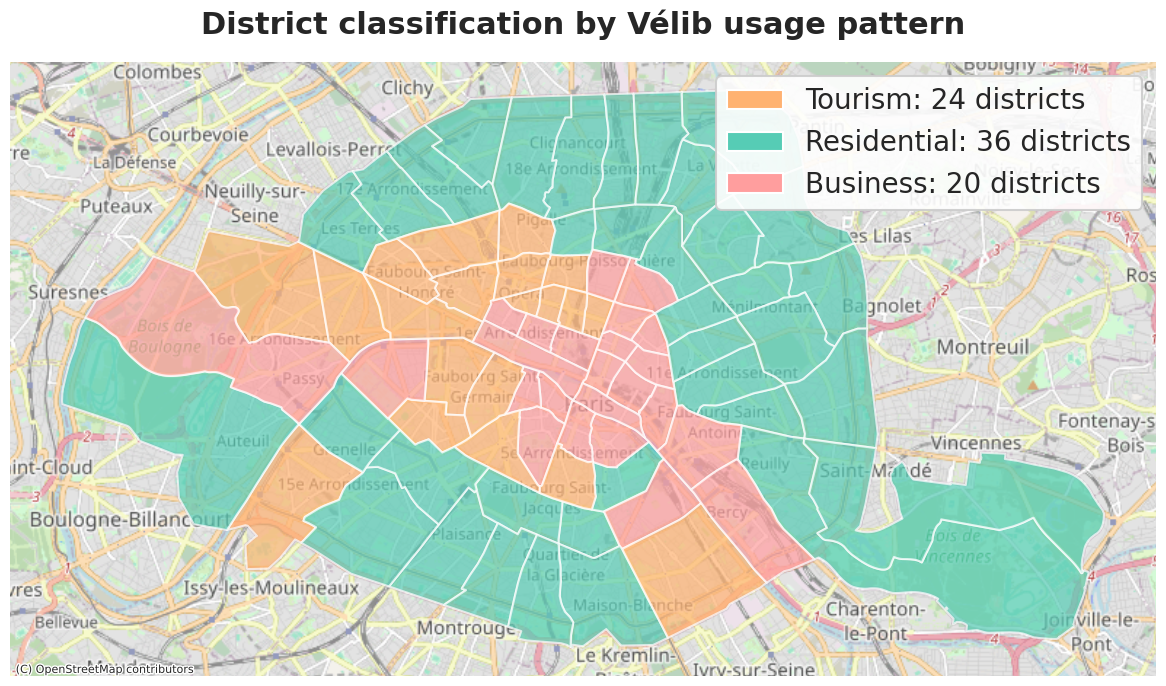


🎯 DISTRIBUTION BY TYPE:
type
Residential    36
Tourism        24
Business       20
Name: count, dtype: int64

📊 Total districts analyzed: 80


In [31]:
# Cluster interpretation and merge with districts
interpretation = ["Tourism","Residential","Business"]
colors = ["#FFB271","#56CCB5", "#FF9E9E"]

classification = pd.DataFrame({
    "l_qu": labels,
    "type": [interpretation[classe] for classe in model.labels_]
})

districts_classified = districts.merge(classification, on="l_qu")

print("📋 District classification:")
display(districts_classified[["l_qu", "type"]].head())

# --- Mapping ---
fig, ax = plt.subplots(figsize=(12, 10))

# Coordinate system conversion
districts_classified = districts_classified.to_crs(epsg=3857)

# Custom color mapping
color_map = {interpretation[i]: colors[i] for i in range(len(interpretation))}

# Plot map
districts_classified.plot(
    column="type",
    ax=ax,
    alpha=0.7,
    edgecolor="white",
    linewidth=1.5,
    categorical=True,
    cmap=ListedColormap([color_map[cat] for cat in interpretation]),
    legend=False  # We'll create a custom legend
)

# Add basemap
ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    alpha=0.8
)

# Customization
ax.set_title(
    "District classification by Vélib usage pattern",
    fontsize=22,
    fontweight='bold',
    pad=20
)
ax.set_axis_off()

# --- Create custom legend with statistics ---
stats = districts_classified["type"].value_counts()
legend_elements = [
    Patch(facecolor=color_map[typ], edgecolor='white',
          label=f"{typ}: {stats[typ]} districts")
    for typ in interpretation
]

ax.legend(
    handles=legend_elements,
    loc="upper right",
    bbox_to_anchor=(1, 1),
    frameon=True,
    fontsize=20,
    framealpha=0.9
)

plt.tight_layout()
plt.savefig("ALLcluster.png", dpi=150, bbox_inches='tight')
plt.show()

# --- Detailed summary ---
print("\n🎯 DISTRIBUTION BY TYPE:")
print(stats)
print(f"\n📊 Total districts analyzed: {len(districts_classified)}")

In [29]:
# --- Convert time_stamp to datetime ---
occupation_data['time_stamp'] = pd.to_datetime(occupation_data['time_stamp'], errors='coerce')

# --- Extract temporal features ---
occupation_data['hour'] = occupation_data['time_stamp'].dt.hour
occupation_data['dayofweek'] = occupation_data['time_stamp'].dt.dayofweek

# --- Encode districts ---
le = LabelEncoder()
occupation_data['l_qu_encoded'] = le.fit_transform(occupation_data['l_qu'])

# --- Define features and target ---
features = ['l_qu_encoded', 'hour', 'dayofweek']
X = occupation_data[features]
y = occupation_data['num_bikes_available']

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

# --- Train XGBoost ---
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# --- Prediction ---
y_pred = xgb_model.predict(X_test)

# --- Evaluation ---
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R²: {r2:.2f}")

# --- Optional: show first 5 predictions ---
pd.DataFrame({
    'l_qu': le.inverse_transform(X_test['l_qu_encoded']),
    'hour': X_test['hour'],
    'dayofweek': X_test['dayofweek'],
    'y_true': y_test,
    'y_pred': y_pred
}).head()

✅ RMSE: 51.70
✅ R²: 0.80


l_qu  hour  dayofweek  y_true      y_pred
106808        Saint-Merri    20          2     133  108.005684
5216      Arts-et-Métiers    10          6      26   50.521214
102772      Saint-Gervais     4          6      63   91.363342
4404              Arsenal    18          3     115  111.206429
114267  Sainte-Marguerite     6          0     396  331.798584

In [19]:
# --- Convert time_stamp to datetime ---
occupation_data['time_stamp'] = pd.to_datetime(occupation_data['time_stamp'], errors='coerce')

# --- Aggregation by hour ---
occupation_data['hour_floor'] = occupation_data['time_stamp'].dt.floor('h')

# --- Get hourly weather data for Paris ---
location = Point(48.8566, 2.3522)
start = occupation_data['hour_floor'].min()
end = occupation_data['hour_floor'].max()
weather = Hourly(location, start, end).fetch()[['temp','prcp','wspd']]
weather = weather.rename(columns={'temp':'temperature','prcp':'precip','wspd':'wind_speed'})
weather.index = weather.index.floor('h')
weather.reset_index(inplace=True)
weather = weather.rename(columns={'time':'hour_weather'})

# --- Merge Vélib + weather data (with suffixes to avoid duplicates) ---
occupation_data = pd.merge(
    occupation_data,
    weather,
    left_on='hour_floor',
    right_on='hour_weather',
    how='left',
    suffixes=('', '_weather')  # '_weather' suffix to avoid conflicts
)
occupation_data.drop(columns=['hour_weather'], inplace=True)

# --- Extract temporal features ---
occupation_data['hour'] = occupation_data['time_stamp'].dt.hour
occupation_data['dayofweek'] = occupation_data['time_stamp'].dt.dayofweek

# --- Encode districts ---
le = LabelEncoder()
occupation_data['l_qu_encoded'] = le.fit_transform(occupation_data['l_qu'])

# --- Features and target ---
features = ['l_qu_encoded','hour','dayofweek','temperature','precip','wind_speed']
X = occupation_data[features]
y = occupation_data['num_bikes_available']

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

# --- Train XGBoost ---
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# --- Prediction and evaluation ---
y_pred = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R²: {r2:.2f}")

# --- Preview of predictions ---
pd.DataFrame({
    'l_qu': le.inverse_transform(X_test['l_qu_encoded']),
    'hour': X_test['hour'],
    'dayofweek': X_test['dayofweek'],
    'temperature': X_test['temperature'],
    'precip': X_test['precip'],
    'wind_speed': X_test['wind_speed'],
    'y_true': y_test,
    'y_pred': y_pred
}).head()

✅ RMSE: 51.64
✅ R²: 0.81


l_qu  hour  dayofweek  temperature  precip  wind_speed  \
106808        Saint-Merri    20          2         16.0     1.3        13.0   
5216      Arts-et-Métiers    10          6         26.0     0.0        17.0   
102772      Saint-Gervais     4          6         15.0     0.0         6.0   
4404              Arsenal    18          3         14.2     0.2        15.0   
114267  Sainte-Marguerite     6          0         17.9     0.0        13.0   

        y_true      y_pred  
106808     133  114.382965  
5216        26   51.154598  
102772      63   89.346375  
4404       115  106.869331  
114267     396  321.718231

In [20]:
# --- Convert time_stamp to datetime ---
occupation_data['time_stamp'] = pd.to_datetime(occupation_data['time_stamp'], errors='coerce')

# --- Aggregation by hour ---
occupation_data['hour_floor'] = occupation_data['time_stamp'].dt.floor('h')

# --- Remove existing weather columns to avoid conflicts ---
for col in ['temperature','precip','wind_speed']:
    if col in occupation_data.columns:
        occupation_data.drop(columns=[col], inplace=True)

# --- Get hourly weather data for Paris ---
location = Point(48.8566, 2.3522)
start = occupation_data['hour_floor'].min()
end = occupation_data['hour_floor'].max()
weather = Hourly(location, start, end).fetch()[['temp','prcp','wspd']]
weather = weather.rename(columns={'temp':'temperature','prcp':'precip','wspd':'wind_speed'})
weather.index = weather.index.floor('h')
weather.reset_index(inplace=True)
weather = weather.rename(columns={'time':'hour_weather'})

# --- Merge Vélib + weather data ---
occupation_data = pd.merge(
    occupation_data,
    weather,
    left_on='hour_floor',
    right_on='hour_weather',
    how='left'
)
occupation_data.drop(columns=['hour_weather'], inplace=True)

# --- Temporal features ---
occupation_data['hour'] = occupation_data['time_stamp'].dt.hour
occupation_data['dayofweek'] = occupation_data['time_stamp'].dt.dayofweek

# --- Encode districts ---
le_qu = LabelEncoder()
occupation_data['l_qu_encoded'] = le_qu.fit_transform(occupation_data['l_qu'])

# --- Add district type ---
districts_type = districts_classified[['l_qu','type']].copy()
districts_type.rename(columns={'type':'type_qu'}, inplace=True)  # avoid duplicate
occupation_data = occupation_data.merge(
    districts_type,
    on='l_qu',
    how='left'
)

# --- Encode district type ---
le_type = LabelEncoder()
occupation_data['type_encoded'] = le_type.fit_transform(occupation_data['type_qu'])

# --- Features and target ---
features = ['l_qu_encoded','type_encoded','hour','dayofweek','temperature','precip','wind_speed']
X = occupation_data[features]
y = occupation_data['num_bikes_available']

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

# --- Train XGBoost ---
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# --- Prediction and evaluation ---
y_pred = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R²: {r2:.2f}")

# --- Preview of predictions ---
pd.DataFrame({
    'l_qu': le_qu.inverse_transform(X_test['l_qu_encoded']),
    'type': le_type.inverse_transform(X_test['type_encoded']),
    'hour': X_test['hour'],
    'dayofweek': X_test['dayofweek'],
    'temperature': X_test['temperature'],
    'precip': X_test['precip'],
    'wind_speed': X_test['wind_speed'],
    'y_true': y_test,
    'y_pred': y_pred
}).head()

✅ RMSE: 39.06
✅ R²: 0.89


l_qu         type  hour  dayofweek  temperature  precip  \
106808        Saint-Merri      Tourism    20          2         16.0     1.3   
5216      Arts-et-Métiers      Tourism    10          6         26.0     0.0   
102772      Saint-Gervais      Tourism     4          6         15.0     0.0   
4404              Arsenal      Tourism    18          3         14.2     0.2   
114267  Sainte-Marguerite  Residential     6          0         17.9     0.0   

        wind_speed  y_true      y_pred  
106808        13.0     133  130.760422  
5216          17.0      26   47.642010  
102772         6.0      63   75.257172  
4404          15.0     115  121.625740  
114267        13.0     396  363.917603

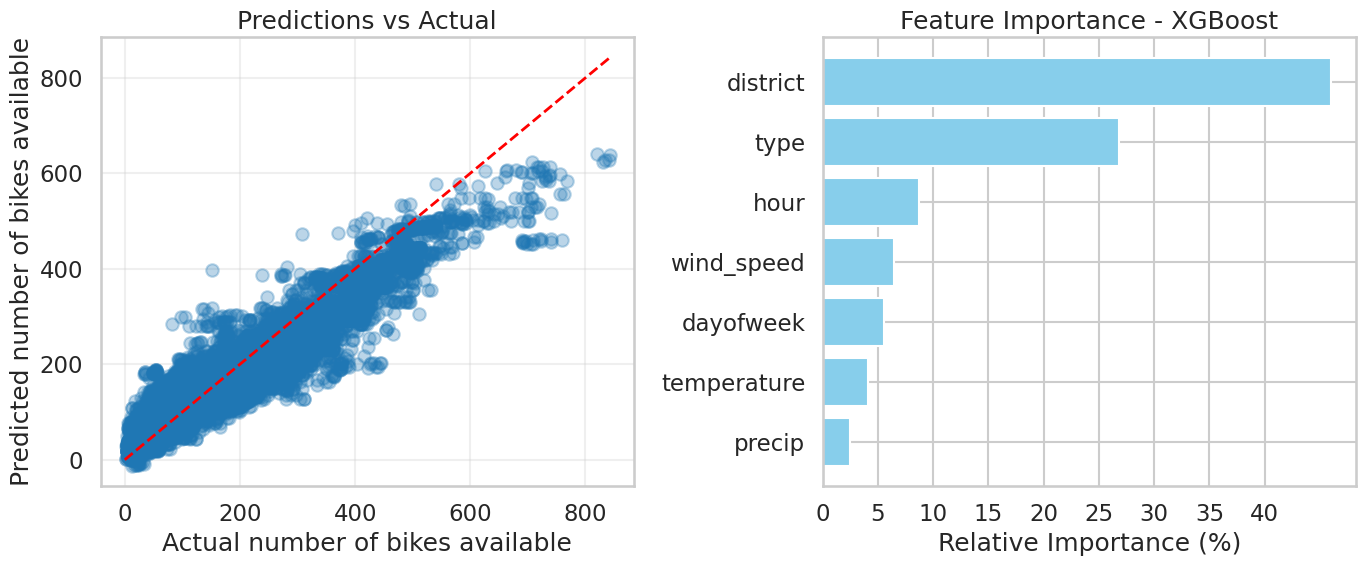

feature  importance_%
0     district     45.956787
1         type     26.769762
2         hour      8.708034
6   wind_speed      6.413254
3    dayofweek      5.512319
4  temperature      4.119827
5       precip      2.520017

In [21]:
# --- Prepare feature names for readability ---
feature_names_readable = []
for f in X.columns:
    if f == "l_qu_encoded":
        feature_names_readable.append("district")
    elif f == "type_encoded":
        feature_names_readable.append("type")
    else:
        feature_names_readable.append(f)

# --- Importance of features ---
importance = xgb_model.feature_importances_

# Convert to percentage
importance_percent = 100 * importance / importance.sum()

# Sort descending
sorted_idx = np.argsort(importance_percent)[::-1]
importance_sorted = importance_percent[sorted_idx]
feature_names_sorted = [feature_names_readable[i] for i in sorted_idx]

# --- Create side-by-side plots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left panel: Predictions vs Actual
axes[0].scatter(y_test, y_pred, alpha=0.3)
axes[0].plot([0, max(y_test)], [0, max(y_test)], 'r--', linewidth=2)
axes[0].set_xlabel("Actual number of bikes available")
axes[0].set_ylabel("Predicted number of bikes available")
axes[0].set_title("Predictions vs Actual")
axes[0].grid(True, alpha=0.3)

# Right panel: Feature Importance
axes[1].barh(feature_names_sorted, importance_sorted, color='skyblue')
axes[1].invert_yaxis()
axes[1].set_title("Feature Importance - XGBoost")
axes[1].set_xlabel("Relative Importance (%)")
axes[1].set_xticks(range(0, 45, 5))  # graduated in 5% steps

plt.tight_layout()
plt.savefig("resFIT.png", dpi=150, bbox_inches='tight')
plt.show()

# --- Optional: feature importance table ---
importance_table = pd.DataFrame({
    'feature': feature_names_readable,
    'importance_%': importance_percent
}).sort_values(by='importance_%', ascending=False)

display(importance_table)


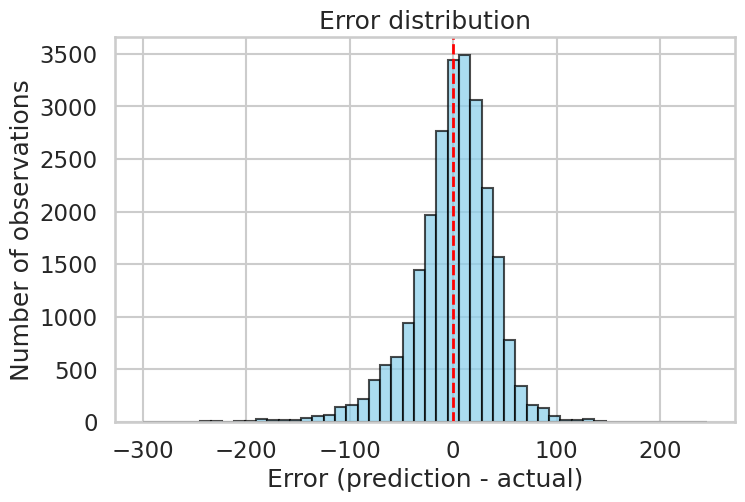

In [22]:
errors = y_pred - y_test

plt.figure(figsize=(8,5))
plt.hist(errors, bins=50, color='skyblue', edgecolor='k', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Error (prediction - actual)")
plt.ylabel("Number of observations")
plt.title("Error distribution")
plt.show()


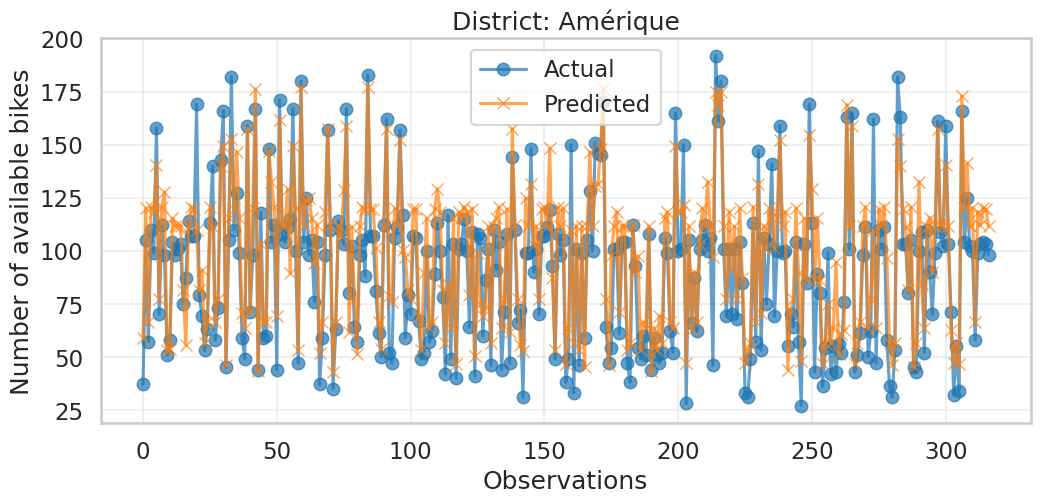

In [23]:
quartier_sample = le.inverse_transform([0])[0]
mask = X_test['l_qu_encoded'] == 0

plt.figure(figsize=(12,5))
plt.plot(y_test[mask].values, label="Actual", marker='o', alpha=0.7)
plt.plot(y_pred[mask], label="Predicted", marker='x', alpha=0.7)
plt.xlabel("Observations")
plt.ylabel("Number of available bikes")
plt.title(f"District: {quartier_sample}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


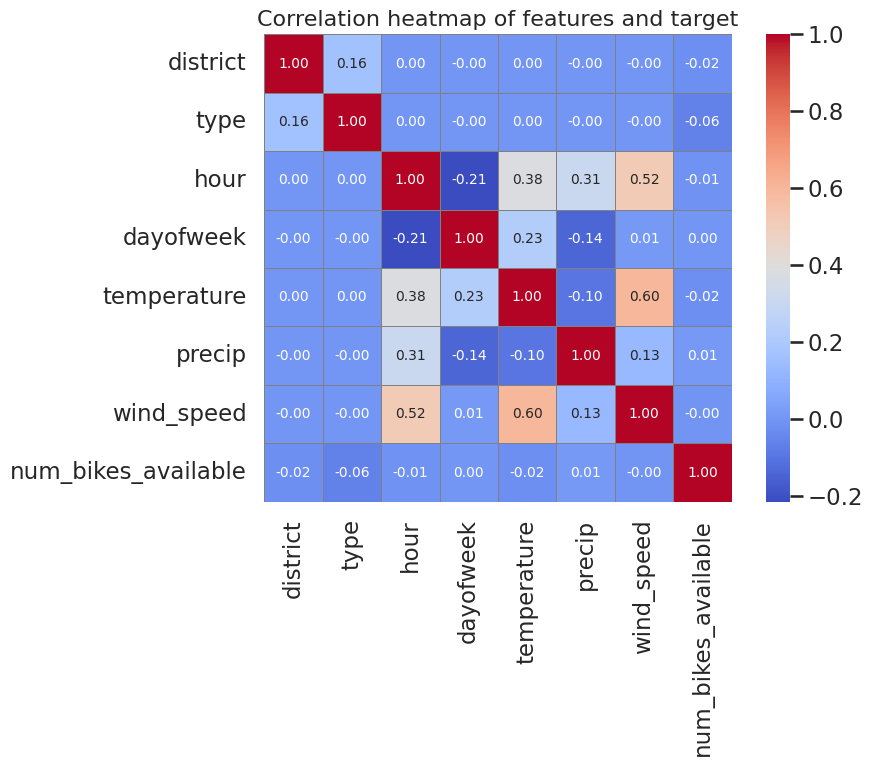

In [24]:
# --- Features + target ---
features = ['l_qu_encoded','type_encoded','hour','dayofweek','temperature','precip','wind_speed']
target = 'num_bikes_available'

# Create a DataFrame with all the columns we want to analyze
df_corr = occupation_data[features + [target]].copy()

# Rename encoded columns to readable names
df_corr = df_corr.rename(columns={
    'l_qu_encoded': 'district',
    'type_encoded': 'type'
})

# Compute the correlation matrix
corr_matrix = df_corr.corr()

# --- Heatmap ---
plt.figure(figsize=(10,8))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    cbar=True, 
    square=True,
    linewidths=0.5, 
    linecolor='gray',
    annot_kws={"size":10}
)

plt.title("Correlation heatmap of features and target", fontsize=16)
plt.tight_layout()
plt.show()
